# Git clone GCNN library

In [1]:
# Git clone gcnn and setup lib
! git clone https://github.com/tscohen/GrouPy.git
! cp -r GrouPy/* .
! ls
! python setup.py install
! rm -rf GrouPy/

Cloning into 'GrouPy'...
remote: Enumerating objects: 221, done.
remote: Total 221 (delta 0), reused 0 (delta 0), pack-reused 221
Receiving objects: 100% (221/221), 167.17 KiB | 704.00 KiB/s, done.
Resolving deltas: 100% (112/112), done.
groupy	LICENSE      p4_fmaps.png   README.md	      sample_data
GrouPy	p4_anim.gif  p4m_fmaps.png  requirements.txt  setup.py
running install
running build
running build_py
creating build
creating build/lib.linux-x86_64-2.7
creating build/lib.linux-x86_64-2.7/groupy
copying groupy/__init__.py -> build/lib.linux-x86_64-2.7/groupy
creating build/lib.linux-x86_64-2.7/groupy/garray
copying groupy/garray/test_garray.py -> build/lib.linux-x86_64-2.7/groupy/garray
copying groupy/garray/__init__.py -> build/lib.linux-x86_64-2.7/groupy/garray
copying groupy/garray/Ot_array.py -> build/lib.linux-x86_64-2.7/groupy/garray
copying groupy/garray/D4h_array.py -> build/lib.linux-x86_64-2.7/groupy/garray
copying groupy/garray/O_array.py -> build/lib.linux-x86_64-2.7/gro

# Import necessary package

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import shutil
import datetime
import math
from random import randint

# GCNN library
from groupy.gconv.tensorflow_gconv.splitgconv2d import gconv2d, gconv2d_util

print(tf.__version__)

1.12.0-rc1


# Import dataset

In [3]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


# Nomalize all the data between 0 - 1 and reshape the data shape

In [0]:
train_images = train_images / 255.0
train_images = np.reshape(train_images, (-1,28,28,1))
train_images = np.concatenate((train_images, train_images, train_images), axis=3)
test_images = test_images / 255.0
test_images = np.reshape(test_images, (-1,28,28,1))
test_images = np.concatenate((test_images, test_images, test_images), axis=3)


# Try to print the image and shape of data

In [0]:
# Labels array
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [6]:
print'Train data shape: ', train_images.shape
print'Train labels shape: ', train_labels.shape
print'Test data shape: ', test_images.shape
print'Test labels shape: ', test_labels.shape

Train data shape:  (60000, 28, 28, 3)
Train labels shape:  (60000,)
Test data shape:  (10000, 28, 28, 3)
Test labels shape:  (10000,)


In [7]:
print(tf.shape(train_images[0][:,:][1]))
print(tf.shape(train_images[0][:,:,1]))
print(tf.shape(train_images[0,:,:,1]))
print(train_images[0][:,:])

Tensor("Shape:0", shape=(2,), dtype=int32)
Tensor("Shape_1:0", shape=(2,), dtype=int32)
Tensor("Shape_2:0", shape=(2,), dtype=int32)
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


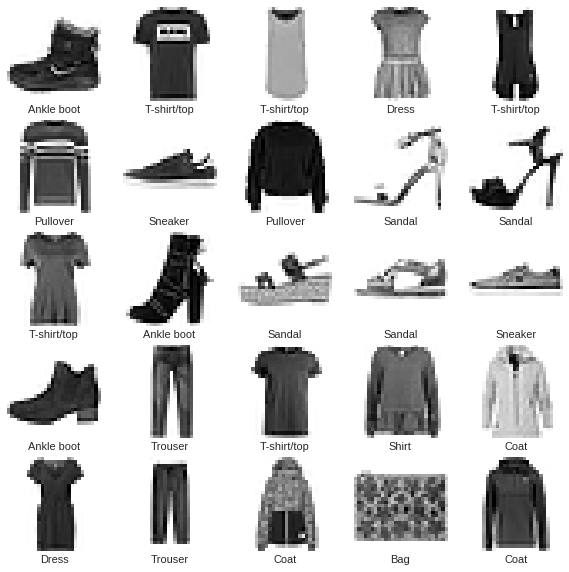

In [8]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i][:,:,0], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

# Define global variable

In [0]:
# Record gcnn accuracy and the best model path
gcnn_a = []
best_gcnn_model_path = ''

# Record cnn accuracy and the best model path
cnn_a = []
best_cnn_model_path = ''

In [0]:
# Define global variable
MODEL_TYPE = 'gcnn'

# Initail model folder and some global variable
model_path = ''

if MODEL_TYPE == 'cnn':
    model_path = './model-densenet-cnn'
    cnn_a = []
    best_cnn_model_path = ''
else:
    model_path = './model-densenet-gcnn'
    gcnn_a = []
    best_gcnn_model_path = ''

shutil.rmtree(model_path, ignore_errors=True)
os.makedirs(model_path)

In [0]:
# Define static variable
IMG_SIZE_HEIGHT = 28
IMG_SIZE_WIDTH = 28
NUM_CLASSES = 10
INIT_LEARNING_RATE = 0.02
CHANGE_IN_LEARNING_RATE = 0.5
NUM_STEPS = 500
DISPLAY_STEPS = 100
NUM_OF_EPOCH = 5
OVER_BEST_EPOCH_LIMIT = 2
BATCH_SIZE = 1024
TESTING_BATCH_SIZE = 3000

# Define placeholder
features_placeholder = tf.placeholder(tf.float32, [None, IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH, 3],
                                      name='features_placeholder')
labels_placeholder = tf.placeholder(tf.int32, [None,], name='labels_placeholder')
learning_rate = tf.placeholder(tf.float32, name='learning_rate')

# Due to GPU resource, separate several batch
split_factor = int(math.ceil(float(test_labels.size) / TESTING_BATCH_SIZE))
test_images_batch = np.array(np.array_split(test_images, split_factor))
test_labels_batch = np.array(np.array_split(test_labels, split_factor))

# Get mini batch

In [0]:
def next_batch(start_index, end_index, idx):

    if end_index > train_labels.size:
        pro_idx = np.arange(0, train_labels.size)
        np.random.shuffle(pro_idx)
        idx = np.concatenate((idx,pro_idx))  
        
        train_features_shuffle, train_labels_shuffle = extract_mini_batch(start_index, end_index, idx)
        
        # remove end_index of idx
        idx = pro_idx
        
        return train_features_shuffle, train_labels_shuffle, True, idx
    else:
        train_features_shuffle, train_labels_shuffle = extract_mini_batch(start_index, end_index, idx)
        return train_features_shuffle, train_labels_shuffle, False, idx
  
  
def extract_mini_batch(start_index, end_index, idx):
  
    # Extract batch size of features and labels by idx
    train_features_shuffle = [train_images[idx[i]] for i in range(start_index,end_index)]
    train_labels_shuffle = [train_labels[idx[i]] for i in range(start_index,end_index)]
    
    # Change the array to np array
    train_features_shuffle = np.array(train_features_shuffle)
    train_labels_shuffle = np.array(train_labels_shuffle)
    return train_features_shuffle, train_labels_shuffle


# Denfine cnn, pooling, gcnn, batch nomlization method

In [0]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

  
def channels(x):
    return int(x.get_shape()[-1])

  
def batch_normalization(x):
    print "Batch Norm"
    eps = 1e-5
    gamma = tf.Variable(tf.constant(1.0, shape=[channels(x)]))
    beta = tf.Variable(tf.constant(0.0, shape=[channels(x)]))
    mean, variance = tf.nn.moments(x, [0, 1, 2], keep_dims=False)
    return tf.nn.batch_normalization(x, mean, variance, beta, gamma, eps)
  
  
def tf_conv2d_layer(features, num_filters, filter_size, strides, padding):
    
    # Define filter size and strides
    filter_height, filter_width = filter_size
    stride_height, stride_width = strides

    # Create weight and bias variable
    weight = weight_variable([filter_height, filter_width, features.get_shape().as_list()[3], num_filters])
    bias = bias_variable([num_filters])
    tf.add_to_collection('loss', weight)

    # Create conv layer NWHC
    conv = tf.nn.conv2d(features, weight, strides=[1, stride_height, stride_width, 1], padding=padding)

    # Add bias
    y = tf.nn.bias_add(conv, bias)
    
    # Batch normalization before activation function
    y = batch_normalization(y)
    
    # Reture a non-linear conv layer
    return tf.nn.relu(y)


def tf_gconv2d_layer(features, channels_in_out, filter_size, strides, padding, h_in_out):

    # Define filter size and strides
    h_input, h_output = h_in_out
    in_channels, out_channels = channels_in_out
    stride_height, stride_width = strides

    gconv_indices, gconv_shape_info, w_shape = gconv2d_util(
        h_input=h_input, h_output=h_output, in_channels=in_channels, out_channels=out_channels, ksize=filter_size)

    # Create weight and bias variable
    weight = weight_variable(w_shape)
    tf.add_to_collection('loss', weight)

    # Create conv layer NWHC
    gconv = gconv2d(input=features, filter=weight, strides=[1, stride_height, stride_width, 1], padding=padding,
                gconv_indices=gconv_indices, gconv_shape_info=gconv_shape_info)

    # Add bias
    bias = bias_variable([gconv.get_shape().as_list()[3]])
    y = tf.nn.bias_add(gconv, bias)
    
    # Batch normalization before activation function
    y = batch_normalization(y)
    
    # Reture a non-linear conv layer
    return tf.nn.relu(y)


def tf_max_pool2d_layer(features, pool_size, strides, padding):
    # Define pooling size
    pool_height, pool_width = pool_size
    stride_height, stride_width = strides

    # Create max pool layer
    max_pool_layer = tf.nn.max_pool(
        features,
        ksize=[1, pool_height, pool_width, 1],
        strides=[1, stride_height, stride_width, 1],
        padding=padding)

    return max_pool_layer


def tf_dense_layer(features, units, activation=None):
    # Create weight and bias variable
    weight = weight_variable([features.get_shape().as_list()[1], units])
    bias = bias_variable([units])
    tf.add_to_collection('loss', weight)

    y = tf.nn.bias_add(tf.matmul(features, weight), bias)

    if activation == 'relu':
        return tf.nn.relu(y)
    elif activation == 'softmax':
        return tf.nn.softmax(y)
    else:
        return y

# Define convolution network structure

In [0]:
def conv_net(features, n_classes):

  if MODEL_TYPE == 'gcnn':
    
    with tf.name_scope("layer1"):
        gconv_layer1 = tf_gconv2d_layer(
            features=tf.convert_to_tensor(features),
            channels_in_out=(3, 4 ),
            filter_size=5,
            strides=(1, 1),
            padding='SAME',
            h_in_out=('Z2', 'D4'))
        #gconv_layer1 = tf.identity(tf.nn.dropout(gconv_layer1, 0.25))
        print 'layer 1: {}'.format(gconv_layer1.get_shape())
        
    with tf.name_scope("layer2"):
        pool_layer2 = tf_max_pool2d_layer(
            features=gconv_layer1,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='SAME')
        print 'layer 2: {}'.format(pool_layer2.get_shape())
    
    with tf.name_scope("layer3"):
        gconv_layer3 = tf_gconv2d_layer(
            features=pool_layer2,
            channels_in_out=(pool_layer2.get_shape().as_list()[3] / 8, 8),
            filter_size=3,
            strides=(1, 1),
            padding='SAME',
            h_in_out=('D4', 'D4'))
        print 'layer 3: {}'.format(gconv_layer3.get_shape())
    
    with tf.name_scope("layer4"):
        pool_layer4 = tf_max_pool2d_layer(
            features=gconv_layer3,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='SAME')
        print 'layer 4: {}'.format(pool_layer4.get_shape())
        
    
    with tf.name_scope("layer5"):
        gconv_layer5 = tf_gconv2d_layer(
            features=pool_layer4,
            channels_in_out=(pool_layer4.get_shape().as_list()[3] / 8, 16),
            filter_size=3,
            strides=(1, 1),
            padding='SAME',
            h_in_out=('D4', 'D4'))
        print 'layer 5: {}'.format(gconv_layer5.get_shape())

    with tf.name_scope("layer6"):
        pool_layer6 = tf_max_pool2d_layer(
            features=gconv_layer5,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='SAME')
        print 'layer 6: {}'.format(pool_layer6.get_shape())

        
    with tf.name_scope("layer7"):
        pool_shape_list = pool_layer6.get_shape().as_list()
        flat_layer7 = tf.reshape(
            pool_layer6,
            shape=[-1, pool_shape_list[1] * pool_shape_list[2] * pool_shape_list[3]])
        print 'layer 7: {}'.format(flat_layer7.get_shape())
    
    # Go to fully connected layer
    with tf.name_scope("layer8"):
        dens_layer8 = tf_dense_layer(
            features=flat_layer7,
            units=128)
        dens_layer8 = tf.identity(tf.nn.dropout(dens_layer8, 0.6))
        print 'layer 8: {}'.format(dens_layer8.get_shape())
    
    
    with tf.name_scope("layer9"):
        dens_layer9 = tf_dense_layer(
            features=dens_layer8,
            units=n_classes)
    
        print 'layer 9: {}'.format(dens_layer9.get_shape())
    
    return dens_layer9
    
  else:
    
    with tf.name_scope("layer1"):
        gconv_layer1 = tf_conv2d_layer(
            features=tf.convert_to_tensor(features),
            num_filters=32,
            filter_size=(5, 5),
            strides=(1, 1),
            padding='SAME')
        print 'layer 1: {}'.format(gconv_layer1.get_shape())
           
    with tf.name_scope("layer2"):
        pool_layer2 = tf_max_pool2d_layer(
            features=gconv_layer1,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='SAME')
        print 'layer 2: {}'.format(pool_layer2.get_shape())

    with tf.name_scope("layer3"):
        gconv_layer3 = tf_conv2d_layer(
            features=features,
            num_filters=64,
            filter_size=(3, 3),
            strides=(1, 1),
            padding='SAME')
        print 'layer 3: {}'.format(gconv_layer3.get_shape())

    with tf.name_scope("layer4"):
        pool_layer4 = tf_max_pool2d_layer(
            features=gconv_layer3,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='SAME')
        print 'layer 4: {}'.format(pool_layer4.get_shape())
        
    with tf.name_scope("layer5"):
        gconv_layer5 = tf_conv2d_layer(
            features=features,
            num_filters=128,
            filter_size=(2, 2),
            strides=(1, 1),
            padding='SAME')
        print 'layer 5: {}'.format(gconv_layer5.get_shape())

    with tf.name_scope("layer6"):
        pool_layer6 = tf_max_pool2d_layer(
            features=gconv_layer5,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='SAME')
        print 'layer 6: {}'.format(pool_layer6.get_shape())
        
    with tf.name_scope("layer7"):
        pool_shape_list = pool_layer6.get_shape().as_list()
        flat_layer7 = tf.reshape(
            pool_layer6,
            shape=[-1, pool_shape_list[1] * pool_shape_list[2] * pool_shape_list[3]])
        print 'layer 7: {}'.format(flat_layer7.get_shape())
    
    # Go to fully connected layer
    with tf.name_scope("layer8"):
        dens_layer8 = tf_dense_layer(
            features=flat_layer7,
            units=128)
        dens_layer8 = tf.identity(tf.nn.dropout(dens_layer8, 0.6))
        print 'layer 8: {}'.format(dens_layer8.get_shape())
    
    
    with tf.name_scope("layer9"):
        dens_layer9 = tf_dense_layer(
            features=dens_layer8,
            units=n_classes)
    
        print 'layer 9: {}'.format(dens_layer9.get_shape())
    
    
    return dens_layer9


# Training with CNN and GCNN
Remember everytime start training, please run the part of "Define global variable" to initial some record and modify the MODEL_TYPE

In [0]:
# Construct model
logits = conv_net(features_placeholder, NUM_CLASSES)

# Define loss and optimizer
with tf.name_scope("cost"):
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=tf.cast(labels_placeholder, dtype=tf.int32)))
    
    # L2
    weight_list = tf.get_collection('loss')
    total_l2_loss = 0.0
    for i in range(len(weight_list)):
        total_l2_loss += tf.nn.l2_loss(weight_list[i])
      
    loss_l2 = loss_op + 0.001 * total_l2_loss
    
    optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_l2,
                                  global_step=tf.train.get_global_step())

# Contruct prediction model for evaluation
with tf.name_scope("accuracy"):
    prediction = tf.nn.softmax(logits, name='prediction')
    correct_pred = tf.equal(tf.argmax(prediction, 1), tf.cast(labels_placeholder, tf.int64))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
# Start training
with tf.Session() as sess:
   
    # Run the initializer
    sess.run(tf.global_variables_initializer())
    
    # For future retore the model (Session bundle) to predict image
    saver = tf.train.Saver()

    # Start time
    start_ts = datetime.datetime.now()
    
    # For early stopping
    best_loss = float('inf')
    
    epoch_learning_rate = INIT_LEARNING_RATE
    for epoch in range(NUM_OF_EPOCH):
        
        epoch_learning_rate *= CHANGE_IN_LEARNING_RATE
        print '\n==============Epoch {} start (learning rate: {})================'.format(epoch, epoch_learning_rate)
        
        step_loss = 0.0
        start_index = 0
        end_index = start_index + BATCH_SIZE
        idx = np.arange(0 , train_labels.size)
        np.random.shuffle(idx)
    
        for step in range(1, NUM_STEPS + 1):

            train_features_shuffle, train_labels_shuffle, reset, idx_new = next_batch(
                start_index,
                end_index,
                idx)
          
            idx = idx_new
            if reset:
                start_index = 0
                end_index = start_index + BATCH_SIZE
            else:
                # Increase the start and end index
                start_index += BATCH_SIZE
                end_index += BATCH_SIZE
            
            # Run optimization op (backprop)
            sess.run(train_op, feed_dict={
                features_placeholder: train_features_shuffle,
                labels_placeholder: train_labels_shuffle,
                learning_rate: epoch_learning_rate})

            # Every x step print the summary
            if step % DISPLAY_STEPS == 0 or step == 1:

                # Calculate batch loss and accuracy
                loss, acc = sess.run([loss_op, accuracy],
                                              feed_dict={features_placeholder: train_features_shuffle,
                                                         labels_placeholder: train_labels_shuffle,
                                                         learning_rate: epoch_learning_rate})
                print("Step " + str(step) + ", Minibatch Loss= " + \
                      "{:.4f}".format(loss) + ", Training Accuracy= " + \
                      "{:.3f}".format(acc) + ", Time= " + \
                      "{}s".format((datetime.datetime.now() - start_ts).total_seconds()))
              
                # Calculate full set testing accuracy (Due to GPU resource, separate several segment)
                total_test_accuracy = 0.0
                
                for i in range(split_factor):
                  total_test_accuracy += sess.run(accuracy, feed_dict={features_placeholder: test_images_batch[i],
                                                      labels_placeholder: test_labels_batch[i],
                                                      learning_rate: epoch_learning_rate})
                test_acc = total_test_accuracy/split_factor
                print "Testing Accuracy: {}".format(test_acc) 
                
                # Record each display accuracy for plot graph
                if not (epoch == 0 and step == 1):
                    if MODEL_TYPE == 'cnn':
                        cnn_a.append(test_acc)
                    else:
                        gcnn_a.append(test_acc)

                start_ts = datetime.datetime.now()
                
                # Training early stop 
                if loss < best_loss:
                  
                    # We can restore the varable to check the content
                    save_path = saver.save(sess, model_path + '/model/epoch-' + str(epoch))
                    print("Model saved in file: {}, Step: {}".format(save_path, step))
                    
                    best_loss = loss
                    
                    if MODEL_TYPE == 'cnn':
                        best_cnn_model_path = save_path
                    else:
                        best_gcnn_model_path = save_path
                
                print '\n'
    print 'Finish training!'

# Training log with CNN


Batch Norm

layer 1: (?, 28, 28, 32)

layer 2: (?, 14, 14, 32)

Batch Norm

layer 3: (?, 28, 28, 64)

layer 4: (?, 14, 14, 64)

Batch Norm

layer 5: (?, 28, 28, 128)

layer 6: (?, 14, 14, 128)

layer 7: (?, 25088)

layer 8: (?, 128)

layer 9: (?, 10)


<br>

==============Epoch 0 start (learning rate: 0.01)================

Step 1, Minibatch Loss= 16.0396, Training Accuracy= 0.244, Time= 1.648167s
Testing Accuracy: 0.241000000387

Model saved in file: ./model-densenet-cnn/model/epoch-0, Step: 1


Step 100, Minibatch Loss= 3.0717, Training Accuracy= 0.708, Time= 25.307715s
Testing Accuracy: 0.682000011206

Model saved in file: ./model-densenet-cnn/model/epoch-0, Step: 100


Step 200, Minibatch Loss= 0.6375, Training Accuracy= 0.770, Time= 25.433854s
Testing Accuracy: 0.727399989963

Model saved in file: ./model-densenet-cnn/model/epoch-0, Step: 200


Step 300, Minibatch Loss= 0.6793, Training Accuracy= 0.794, Time= 25.447025s
Testing Accuracy: 0.766399994493


Step 400, Minibatch Loss= 0.5024, Training Accuracy= 0.841, Time= 25.350644s
Testing Accuracy: 0.815999984741

Model saved in file: ./model-densenet-cnn/model/epoch-0, Step: 400


Step 500, Minibatch Loss= 0.4054, Training Accuracy= 0.858, Time= 25.458766s
Testing Accuracy: 0.818300008774

Model saved in file: ./model-densenet-cnn/model/epoch-0, Step: 500



<br>



==============Epoch 1 start (learning rate: 0.005)================

Step 1, Minibatch Loss= 0.4230, Training Accuracy= 0.857, Time= 0.440359s
Testing Accuracy: 0.848399996758


Step 100, Minibatch Loss= 0.3826, Training Accuracy= 0.854, Time= 25.102468s
Testing Accuracy: 0.843999996781

Model saved in file: ./model-densenet-cnn/model/epoch-1, Step: 100


Step 200, Minibatch Loss= 0.3303, Training Accuracy= 0.895, Time= 25.426745s
Testing Accuracy: 0.855000004172

Model saved in file: ./model-densenet-cnn/model/epoch-1, Step: 200


Step 300, Minibatch Loss= 0.4195, Training Accuracy= 0.846, Time= 25.448524s
Testing Accuracy: 0.826999992132


Step 400, Minibatch Loss= 0.3637, Training Accuracy= 0.862, Time= 25.364051s
Testing Accuracy: 0.844900012016


Step 500, Minibatch Loss= 0.3304, Training Accuracy= 0.883, Time= 25.396569s
Testing Accuracy: 0.846399992704


<br>


==============Epoch 2 start (learning rate: 0.0025)================

Step 1, Minibatch Loss= 0.3464, Training Accuracy= 0.880, Time= 0.343464s
Testing Accuracy: 0.865199998021


Step 100, Minibatch Loss= 0.3169, Training Accuracy= 0.900, Time= 25.166624s
Testing Accuracy: 0.865799993277

Model saved in file: ./model-densenet-cnn/model/epoch-2, Step: 100


Step 200, Minibatch Loss= 0.2951, Training Accuracy= 0.890, Time= 25.516158s
Testing Accuracy: 0.857500001788

Model saved in file: ./model-densenet-cnn/model/epoch-2, Step: 200


Step 300, Minibatch Loss= 0.2733, Training Accuracy= 0.906, Time= 25.519607s
Testing Accuracy: 0.862700015306

Model saved in file: ./model-densenet-cnn/model/epoch-2, Step: 300


Step 400, Minibatch Loss= 0.2850, Training Accuracy= 0.897, Time= 25.497343s
Testing Accuracy: 0.86439999938


Step 500, Minibatch Loss= 0.2838, Training Accuracy= 0.906, Time= 25.40255s
Testing Accuracy: 0.869200006127


<br>


==============Epoch 3 start (learning rate: 0.00125)================

Step 1, Minibatch Loss= 0.2962, Training Accuracy= 0.893, Time= 0.342693s
Testing Accuracy: 0.871100008488


Step 100, Minibatch Loss= 0.2718, Training Accuracy= 0.904, Time= 25.188467s
Testing Accuracy: 0.870399996638

Model saved in file: ./model-densenet-cnn/model/epoch-3, Step: 100


Step 200, Minibatch Loss= 0.2858, Training Accuracy= 0.903, Time= 25.520458s
Testing Accuracy: 0.872500002384


Step 300, Minibatch Loss= 0.2928, Training Accuracy= 0.898, Time= 25.429273s
Testing Accuracy: 0.874099999666


Step 400, Minibatch Loss= 0.2402, Training Accuracy= 0.925, Time= 25.42563s
Testing Accuracy: 0.870800003409

Model saved in file: ./model-densenet-cnn/model/epoch-3, Step: 400


Step 500, Minibatch Loss= 0.2724, Training Accuracy= 0.907, Time= 25.515259s
Testing Accuracy: 0.874400004745


<br>


==============Epoch 4 start (learning rate: 0.000625)================

Step 1, Minibatch Loss= 0.3043, Training Accuracy= 0.900, Time= 0.343426s
Testing Accuracy: 0.876299992204


Step 100, Minibatch Loss= 0.2479, Training Accuracy= 0.912, Time= 25.155835s
Testing Accuracy: 0.877300009131


Step 200, Minibatch Loss= 0.2791, Training Accuracy= 0.907, Time= 25.428662s
Testing Accuracy: 0.880900010467


Step 300, Minibatch Loss= 0.2512, Training Accuracy= 0.906, Time= 25.432365s
Testing Accuracy: 0.877199992537


Step 400, Minibatch Loss= 0.2936, Training Accuracy= 0.898, Time= 25.415236s
Testing Accuracy: 0.877499997616


Step 500, Minibatch Loss= 0.2781, Training Accuracy= 0.912, Time= 25.369415s
Testing Accuracy: 0.879800006747


Finish training!

# Training log with GCNN

Batch Norm

layer 1: (?, 28, 28, 32)

layer 2: (?, 14, 14, 32)

Batch Norm

layer 3: (?, 14, 14, 64)

layer 4: (?, 7, 7, 64)

Batch Norm

layer 5: (?, 7, 7, 128)

layer 6: (?, 4, 4, 128)

layer 7: (?, 2048)

layer 8: (?, 128)

layer 9: (?, 10)

<br>

==============Epoch 0 start (learning rate: 0.01)================

Step 1, Minibatch Loss= 5.7523, Training Accuracy= 0.151, Time= 1.026492s
Testing Accuracy: 0.154199998826

Model saved in file: ./model-densenet-gcnn/model/epoch-0, Step: 1


Step 100, Minibatch Loss= 1.9132, Training Accuracy= 0.569, Time= 14.499639s
Testing Accuracy: 0.564899995923

Model saved in file: ./model-densenet-gcnn/model/epoch-0, Step: 100


Step 200, Minibatch Loss= 0.8443, Training Accuracy= 0.751, Time= 14.602003s
Testing Accuracy: 0.736699998379

Model saved in file: ./model-densenet-gcnn/model/epoch-0, Step: 200


Step 300, Minibatch Loss= 0.4720, Training Accuracy= 0.840, Time= 14.602836s
Testing Accuracy: 0.830500006676

Model saved in file: ./model-densenet-gcnn/model/epoch-0, Step: 300


Step 400, Minibatch Loss= 0.3368, Training Accuracy= 0.876, Time= 14.728477s
Testing Accuracy: 0.855599999428

Model saved in file: ./model-densenet-gcnn/model/epoch-0, Step: 400


Step 500, Minibatch Loss= 0.3005, Training Accuracy= 0.901, Time= 14.610491s
Testing Accuracy: 0.863899990916

Model saved in file: ./model-densenet-gcnn/model/epoch-0, Step: 500

<br>

==============Epoch 1 start (learning rate: 0.005)================

Step 1, Minibatch Loss= 0.2728, Training Accuracy= 0.900, Time= 0.423417s
Testing Accuracy: 0.872600004077

Model saved in file: ./model-densenet-gcnn/model/epoch-1, Step: 1


Step 100, Minibatch Loss= 0.3056, Training Accuracy= 0.891, Time= 14.454603s
Testing Accuracy: 0.878200009465


Step 200, Minibatch Loss= 0.2837, Training Accuracy= 0.899, Time= 14.380742s
Testing Accuracy: 0.866300016642


Step 300, Minibatch Loss= 0.2175, Training Accuracy= 0.911, Time= 14.385228s
Testing Accuracy: 0.885799989104

Model saved in file: ./model-densenet-gcnn/model/epoch-1, Step: 300


Step 400, Minibatch Loss= 0.1807, Training Accuracy= 0.938, Time= 14.65429s
Testing Accuracy: 0.878200009465

Model saved in file: ./model-densenet-gcnn/model/epoch-1, Step: 400


Step 500, Minibatch Loss= 0.2291, Training Accuracy= 0.921, Time= 14.632008s
Testing Accuracy: 0.89390000701

<br>

==============Epoch 2 start (learning rate: 0.0025)================

Step 1, Minibatch Loss= 0.2220, Training Accuracy= 0.924, Time= 0.193068s
Testing Accuracy: 0.904599994421


Step 100, Minibatch Loss= 0.1716, Training Accuracy= 0.947, Time= 14.237851s
Testing Accuracy: 0.905999988317

Model saved in file: ./model-densenet-gcnn/model/epoch-2, Step: 100


Step 200, Minibatch Loss= 0.1807, Training Accuracy= 0.940, Time= 14.69422s
Testing Accuracy: 0.904800012708


Step 300, Minibatch Loss= 0.2088, Training Accuracy= 0.922, Time= 14.385155s
Testing Accuracy: 0.905100002885


Step 400, Minibatch Loss= 0.1731, Training Accuracy= 0.941, Time= 14.394177s
Testing Accuracy: 0.909100010991


Step 500, Minibatch Loss= 0.1338, Training Accuracy= 0.963, Time= 14.385196s
Testing Accuracy: 0.909899994731

Model saved in file: ./model-densenet-gcnn/model/epoch-2, Step: 500

<br>

==============Epoch 3 start (learning rate: 0.00125)================

Step 1, Minibatch Loss= 0.1438, Training Accuracy= 0.952, Time= 0.445883s
Testing Accuracy: 0.916500002146


Step 100, Minibatch Loss= 0.1295, Training Accuracy= 0.956, Time= 14.210141s
Testing Accuracy: 0.917199999094

Model saved in file: ./model-densenet-gcnn/model/epoch-3, Step: 100


Step 200, Minibatch Loss= 0.1299, Training Accuracy= 0.955, Time= 14.588322s
Testing Accuracy: 0.916899994016


Step 300, Minibatch Loss= 0.1071, Training Accuracy= 0.966, Time= 14.356916s
Testing Accuracy: 0.915799990296

Model saved in file: ./model-densenet-gcnn/model/epoch-3, Step: 300


Step 400, Minibatch Loss= 0.1256, Training Accuracy= 0.958, Time= 14.568754s
Testing Accuracy: 0.912099987268


Step 500, Minibatch Loss= 0.0944, Training Accuracy= 0.973, Time= 14.351036s
Testing Accuracy: 0.915699988604

Model saved in file: ./model-densenet-gcnn/model/epoch-3, Step: 500

<br>

==============Epoch 4 start (learning rate: 0.000625)================

Step 1, Minibatch Loss= 0.1153, Training Accuracy= 0.969, Time= 0.433492s
Testing Accuracy: 0.915899991989


Step 100, Minibatch Loss= 0.0883, Training Accuracy= 0.979, Time= 14.229927s
Testing Accuracy: 0.918500006199

Model saved in file: ./model-densenet-gcnn/model/epoch-4, Step: 100


Step 200, Minibatch Loss= 0.1052, Training Accuracy= 0.964, Time= 14.574491s
Testing Accuracy: 0.917599990964


Step 300, Minibatch Loss= 0.0838, Training Accuracy= 0.976, Time= 14.38797s
Testing Accuracy: 0.918799981475

Model saved in file: ./model-densenet-gcnn/model/epoch-4, Step: 300


Step 400, Minibatch Loss= 0.1010, Training Accuracy= 0.975, Time= 14.721156s
Testing Accuracy: 0.916400000453


Step 500, Minibatch Loss= 0.0902, Training Accuracy= 0.975, Time= 14.358447s
Testing Accuracy: 0.914400011301


Finish training!

# Plot cnn and gcnn accuracy graph

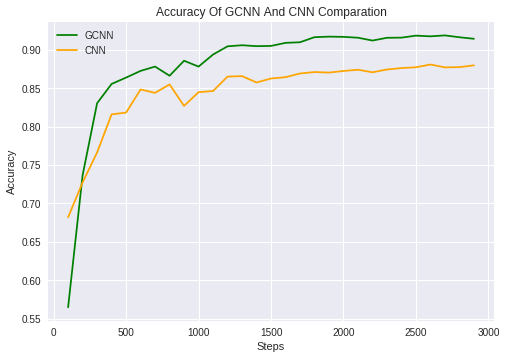

In [18]:
# This is for two type of conv have same step accuarcy record 
total_record_step = (NUM_OF_EPOCH * NUM_STEPS/DISPLAY_STEPS) + (NUM_OF_EPOCH -1)
steps = []

for i in range(total_record_step):
    steps.append((i+1)*DISPLAY_STEPS)

plt.plot(steps[:len(gcnn_a)], gcnn_a, color='g')
plt.plot(steps[:len(cnn_a)], cnn_a, color='orange')

plt.legend(['GCNN', 'CNN'])

plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Accuracy Of GCNN And CNN Comparation')

plt.show()


# Define extract random predict result method 

In [0]:
def extract_predict_result(num_predict_size, extract_num, part_of_test_images, part_of_test_labels, predict_result):
    idx = np.arange(0, num_predict_size)
    np.random.shuffle(idx)  
    
    # Extract batch size of features and labels by idx
    part_of_test_images = [part_of_test_images[idx[i]] for i in range(0,extract_num)]
    part_of_test_labels = [part_of_test_labels[idx[i]] for i in range(0,extract_num)]
    predict_result = [predict_result[idx[i]] for i in range(0,extract_num)]
    
    # Change the array to np array
    part_of_test_images = np.array(part_of_test_images)
    part_of_test_labels = np.array(part_of_test_labels)
    predict_result = np.array(predict_result)
    return part_of_test_images, part_of_test_labels, predict_result

# Predict with gcnn
If you run gcnn first, the predict should be "accuracy/prediction:0" not "accuracy_1/prediction:0" 

INFO:tensorflow:Restoring parameters from ./model-densenet-gcnn/model/epoch-4


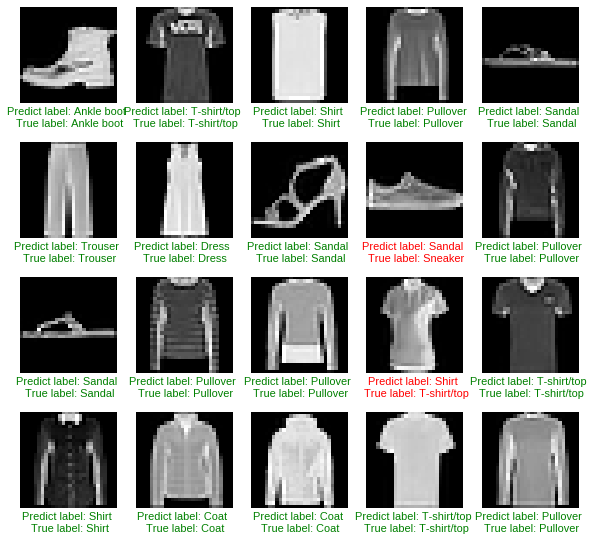

In [37]:
gcnn_graph = tf.Graph()
with tf.Session(graph=gcnn_graph) as sess:

    saver = tf.train.import_meta_graph(best_gcnn_model_path + '.meta')
    saver.restore(sess, best_gcnn_model_path)

    graph = tf.get_default_graph()
    
    # Extract part of test image and label to predict 
    # then random show 20 predict result 
    part_of_test_images = test_images[:256]
    part_of_test_labels = test_labels[:256]
    
    features_placeholder = graph.get_tensor_by_name("features_placeholder:0")
    feed_dict = {features_placeholder:np.array(part_of_test_images)}

    # Output node
    prediction = graph.get_tensor_by_name("accuracy_1/prediction:0")
    pred_result = sess.run(tf.argmax(prediction, 1),feed_dict)
    
    part_of_test_images, part_of_test_labels, pred_result = extract_predict_result(256, 
                                                20,
                                                part_of_test_images, 
                                                part_of_test_labels,
                                                pred_result)
    
    plt.figure(figsize=(10,12))
    for i in range(20):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid('off')

        # Predict result of the image
        predicted_label = pred_result[i]
        true_label = part_of_test_labels[i]
        if predicted_label == true_label:
          color = 'green'
        else:
          color = 'red'

        # Plot predict image
        plt.imshow(part_of_test_images[i])

        predicted_class = class_names[predicted_label]
        true_class = class_names[true_label]
        plt.xlabel("Predict label: {} \n True label: {}".format(predicted_class, true_class),
                                color=color)

    


# Predict with cnn
If you run cnn first, the predict should be "accuracy/prediction:0" not "accuracy_1/prediction:0" 

INFO:tensorflow:Restoring parameters from ./model-densenet-cnn/model/epoch-3


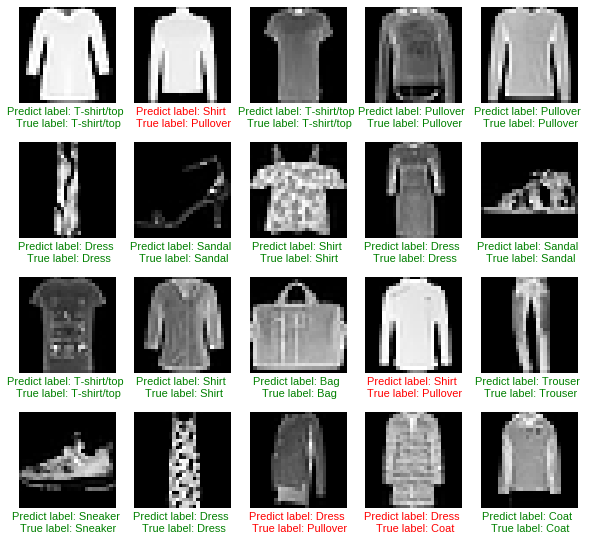

In [41]:
cnn_graph = tf.Graph()
with tf.Session(graph=cnn_graph) as sess:

    saver = tf.train.import_meta_graph(best_cnn_model_path + '.meta')
    saver.restore(sess, best_cnn_model_path)

    graph = tf.get_default_graph()

    # Extract part of test image and label to predict 
    # then random show 20 predict result 
    part_of_test_images = test_images[:256]
    part_of_test_labels = test_labels[:256]
    
    features_placeholder = graph.get_tensor_by_name("features_placeholder:0")
    feed_dict = {features_placeholder:np.array(part_of_test_images)}

    # Output node
    prediction = graph.get_tensor_by_name("accuracy/prediction:0")
    pred_result = sess.run(tf.argmax(prediction, 1),feed_dict)
    
    part_of_test_images, part_of_test_labels, pred_result = extract_predict_result(256, 
                                                20,
                                                part_of_test_images, 
                                                part_of_test_labels,
                                                pred_result)
    
    plt.figure(figsize=(10,12))
    for i in range(20):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid('off')

        # Predict result of the image
        predicted_label = pred_result[i]
        true_label = part_of_test_labels[i]
        if predicted_label == true_label:
          color = 'green'
        else:
          color = 'red'

        # Plot predict image
        plt.imshow(part_of_test_images[i])

        predicted_class = class_names[predicted_label]
        true_class = class_names[true_label]
        plt.xlabel("Predict label: {} \n True label: {}".format(predicted_class, true_class),
                                color=color)